In [375]:
import os

import pandas as pd
import numpy as np
import time
from datetime import datetime
from dateutil import relativedelta

import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

In [414]:
root = '/Users/danielfisher/Projects/kcl-globalgasflaring/data/processed/merged_months/'
at1_monthly_timeseries = pd.read_csv(os.path.join(root, 'at1', 'monthly_time_series.csv'))
at2_monthly_timeseries = pd.read_csv(os.path.join(root, 'at2', 'monthly_time_series.csv'))
ats_monthly_timeseries = pd.read_csv(os.path.join(root, 'ats', 'monthly_time_series.csv'))

In [415]:
for df in [at1_monthly_timeseries, at2_monthly_timeseries, ats_monthly_timeseries]:
    df.drop('Unnamed: 0', 1, inplace=True)
    df['number_of_flares_in_month'] = np.ones(df.shape[0])

In [416]:
at1_annual_timeseries = pd.read_csv(os.path.join(root, 'at1', 'annual_time_series.csv'))
at2_annual_timeseries = pd.read_csv(os.path.join(root, 'at2', 'annual_time_series.csv'))
ats_annual_timeseries = pd.read_csv(os.path.join(root, 'ats', 'annual_time_series.csv'))

In [417]:
for df in [at1_annual_timeseries, at2_annual_timeseries, ats_annual_timeseries]:
    df.drop('Unnamed: 0', 1, inplace=True)
    df['number_of_flares_in_year'] = np.ones(df.shape[0])

In [418]:
at1_annual_counts = at1_annual_timeseries.groupby(['year', 'month']).agg({'number_of_flares_in_year': np.sum})
at1_monthly_counts = at1_monthly_timeseries.groupby(['year', 'month']).agg({'number_of_flares_in_month': np.sum})

at2_annual_counts = at2_annual_timeseries.groupby(['year', 'month']).agg({'number_of_flares_in_year': np.sum})
at2_monthly_counts = at2_monthly_timeseries.groupby(['year', 'month']).agg({'number_of_flares_in_month': np.sum})

ats_annual_counts = ats_annual_timeseries.groupby(['year', 'month']).agg({'number_of_flares_in_year': np.sum})
ats_monthly_counts = ats_monthly_timeseries.groupby(['year', 'month']).agg({'number_of_flares_in_month': np.sum})

## Monthly Counts vs. Annual Counts
The monthly counts are the flares in a given month which were seen at least four times in the following 11 months (i.e. for one year).  The annual counts are all flares seen at least four times in the twelve months from the given month.  Using this we can look at the difference between the flares burning in any given month, and the flares burning over the next twleve months from the given month.  In effect comparing the monthly flares, to the annual flares  

In [420]:
joined_df = ats_monthly_counts.join(ats_annual_counts).reset_index()
joined_df['day'] = np.ones(joined_df.shape[0]).astype('int')
joined_df['datetime'] = pd.to_datetime(joined_df[['year', 'month', 'day']])
joined_df.set_index(['datetime'], inplace=True)
joined_df.drop(['year', 'month', 'day'], 1, inplace=True)

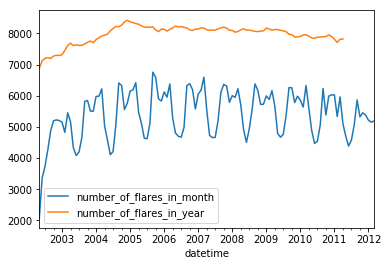

In [421]:
joined_df.plot()
plt.show()

## Investigating trend in monthly flares
Theire is an apparent seasonal trend in the monthly flares.  This is likely due to the solar zenith angle threhsold, and the fact that more of the Northern hemisphere is illuminated in the northern summer months, reducing the opportunities for detection during those months.  Let looks at the monthly timeseries

119


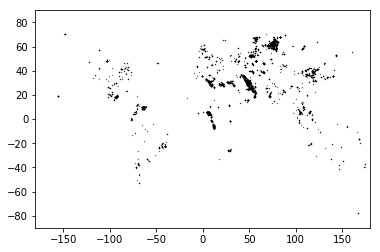

In [422]:
# lets have a look at this issue with the monthly stuff
lon_list = []
lat_list = []
for y, m in sorted(list(set(zip(ats_monthly_timeseries.year, ats_monthly_timeseries.month)))):
    sub_df = ats_monthly_timeseries[(ats_monthly_timeseries.year == y) & 
                                    (ats_monthly_timeseries.month == m)]
    lon_list.append(sub_df.lons.values)
    lat_list.append(sub_df.lats.values)

print len(lon_list)
    
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
ax.set_xlim(( -180, 180))
ax.set_ylim((-90, 90))

scat, = ax.plot([], [], 'ko', markersize=0.25)


# initialization function: plot the background of each frame
def init():
    scat.set_data([], [])
    return (scat,)


def animate(i):
    scat.set_data(lon_list[i], lat_list[i])
    return (scat,)
    
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=119, interval=200, blit=True)

HTML(anim.to_html5_video())

## Annual time series visualisation
So, it is apparent that flare detection goes down in Northern hemisphere summer months due to SZN thresholding.  Lets see the annual detection trends.

108


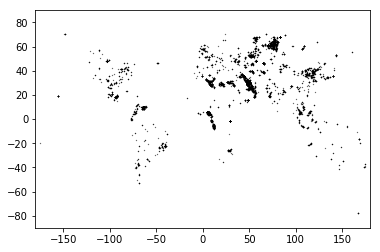

In [423]:
# lets have a look at this issue with the monthly stuff
lon_list = []
lat_list = []
for y, m in sorted(list(set(zip(ats_annual_timeseries.year, ats_annual_timeseries.month)))):
    sub_df = ats_annual_timeseries[(ats_annual_timeseries.year == y) & 
                                    (ats_annual_timeseries.month == m)]
    lon_list.append(sub_df.lons.values)
    lat_list.append(sub_df.lats.values)

print len(lon_list)
    
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
ax.set_xlim(( -180, 180))
ax.set_ylim((-90, 90))

scat, = ax.plot([], [], 'ko', markersize=0.25)


# initialization function: plot the background of each frame
def init():
    scat.set_data([], [])
    return (scat,)


def animate(i):
    scat.set_data(lon_list[i], lat_list[i])
    return (scat,)
    
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(lon_list), interval=200, blit=True)

HTML(anim.to_html5_video())

## Persistent hotspot timeseries analysis
Now let's see how many of the hotspots are persistent throughtout the entire ATSR timeseries from 1991 to 2012.  We pair down the annual timeseries into the following temporal subsets:
* AT1: Aug 1991 - May 1996
* AT2: Jun 1996 - Dec 2002
* ATS: Jan 2003 - March 2012

Once pared down we group by lat and lon, and get a count of the number of occurences of each flaring location.  Any location that does not appear at least four times in each annual epoch is rejected as not being persistent over the timeseries.

In [424]:
for df in [at1_annual_timeseries, at2_annual_timeseries, ats_annual_timeseries]:
    df['day'] = np.ones(df.shape[0]).astype('int')
    df['datetime'] = pd.to_datetime(df[['year', 'month', 'day']])
    df.set_index(['datetime'], inplace=True)
    df.drop(['year', 'month', 'day'], 1, inplace=True)
    
at1_annual_timeseries = at1_annual_timeseries[(at1_annual_timeseries.index >= datetime(1991, 8, 1)) &
                                              (at1_annual_timeseries.index < datetime(1996, 6, 1))]
at2_annual_timeseries = at2_annual_timeseries[(at2_annual_timeseries.index >= datetime(1996, 6, 1)) &
                                              (at2_annual_timeseries.index < datetime(2003, 1, 1))]
ats_annual_timeseries = ats_annual_timeseries[(ats_annual_timeseries.index >= datetime(2003, 1, 1))]

In [425]:
annual_df_merged = pd.concat([at1_annual_timeseries, at2_annual_timeseries, ats_annual_timeseries], ignore_index=False)

In [426]:
# get all the months between the start and end of the time series.
d = relativedelta.relativedelta(annual_df_merged.index.max(),annual_df_merged.index.min())
total_months = d.years*12 + d.months
total_months

236

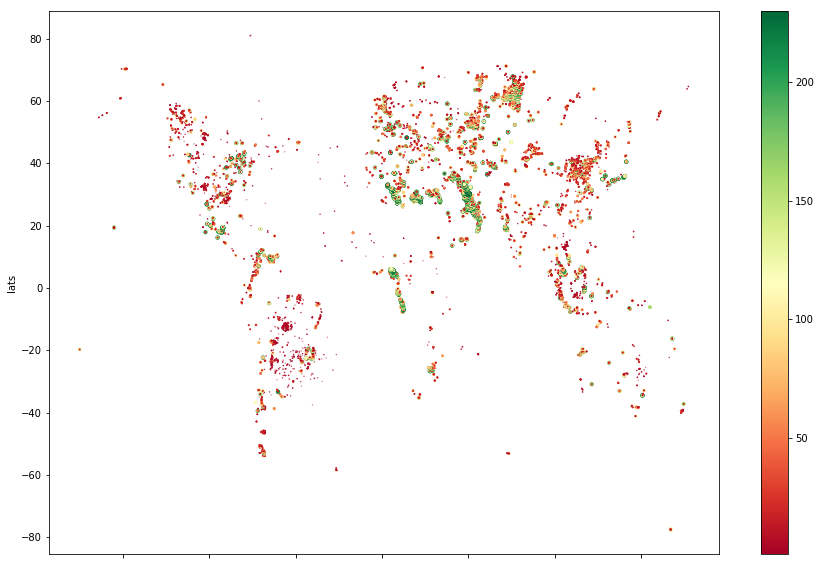

In [427]:
grouped = annual_df_merged.groupby(['lats', 'lons']).agg({'number_of_flares_in_year': np.sum})
grouped.reset_index(inplace=True)

grouped.plot(kind='scatter', x='lons', y='lats',s=grouped.number_of_flares_in_year.values*.05,
             c=grouped.number_of_flares_in_year.values, cmap=plt.cm.RdYlGn, figsize=(15,10))
plt.show()

## Now lets do an initial analysis on the FRP released by each hotspot.  
For this analysis, the monthly flaring is most like the best option, as we then know that we are looking at a flare that was present in each given month.  If we use the annual data, we might be counting flares multiple times, which is not what we want.  What we really need is to see how often we see a given flare.  With this we can more lreiably generate FRP estimates across observations.

In [429]:
annual_df_merged.reset_index(inplace=True)

In [437]:
annual_df_merged['dt_start'] = annual_df_merged.datetime
annual_df_merged['dt_stop'] = annual_df_merged.datetime
annual_df_merged['frp_mean'] = annual_df_merged.frp
annual_df_merged['frp_std'] = annual_df_merged.frp
annual_df_merged['total_observations'] = annual_df_merged.number_of_flares_in_year

In [438]:
grouped = annual_df_merged.groupby(['lats', 'lons']).agg({'total_observations': np.sum,
                                                          'dt_start': np.min,
                                                          'dt_stop': np.max,
                                                          'frp_mean': np.mean,
                                                          'frp_std': np.std})
grouped.head()

dt_stop   frp_std  frp_mean   dt_start  \
lats       lons                                                   
-77.533333 167.083333 2008-08-01  0.147084  1.423598 2006-09-01   
           167.100000 2009-05-01  0.434236  1.816097 2003-01-01   
           167.116667 2010-08-01  0.451786  1.703020 2003-01-01   
           167.133333 2011-04-01  0.345636  1.524977 2003-01-01   
           167.150000 2011-04-01  0.391262  1.584979 2003-01-01   

                       total_observations  
lats       lons                            
-77.533333 167.083333                14.0  
           167.100000                66.0  
           167.116667                92.0  
           167.133333               100.0  
           167.150000               100.0

In [442]:
grouped.reset_index(inplace=True)

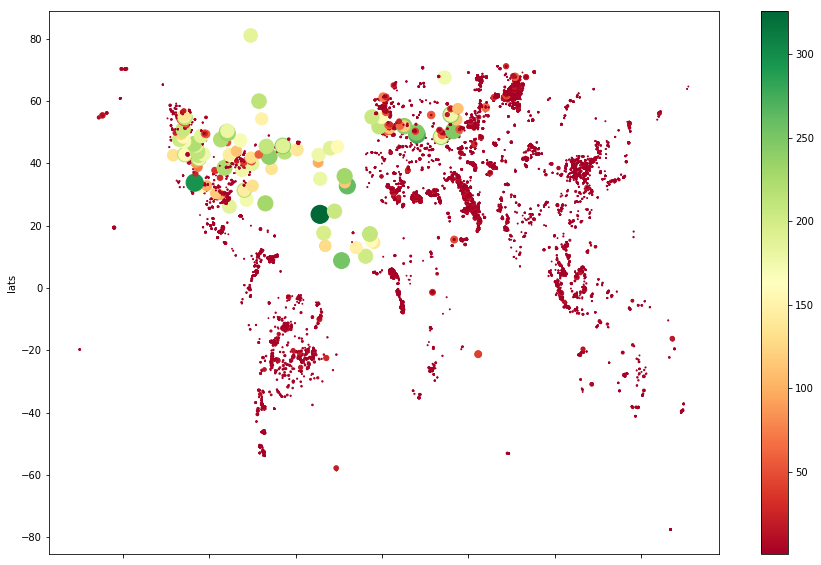

In [444]:
grouped.plot(kind='scatter', x='lons', y='lats',s=grouped.frp_mean,
             c=grouped.frp_mean, cmap=plt.cm.RdYlGn, figsize=(15,10))
plt.show()

The above plot lets us see that there are some dodgy retrievals.  Even the biggest flares that are located in Iraq (and Venezuela?) Do not exceed 50 MW, and are likely even less than this.  So, we need to drop that crap.  

In [446]:
grouped = grouped[grouped.frp_mean < 25]

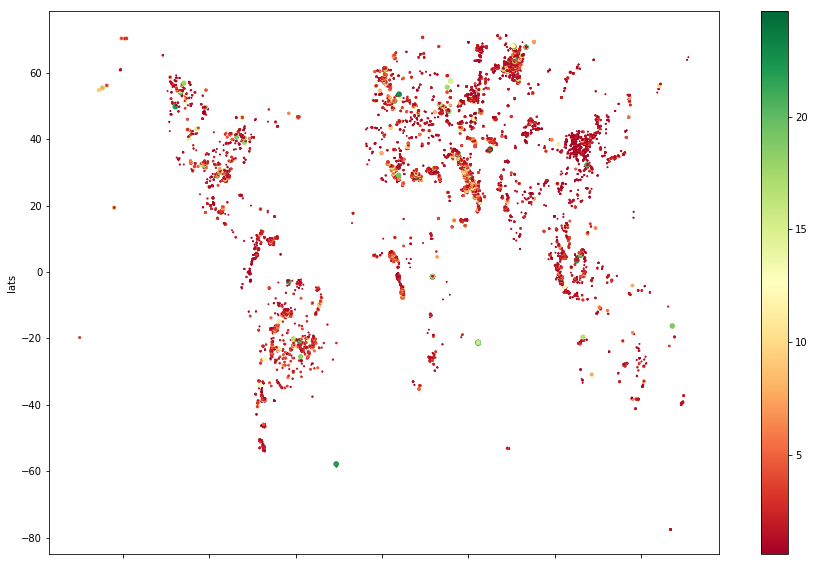

In [449]:
grouped.plot(kind='scatter', x='lons', y='lats',s=grouped.frp_mean,
             c=grouped.frp_mean, cmap=plt.cm.RdYlGn, figsize=(15,10))
plt.show()

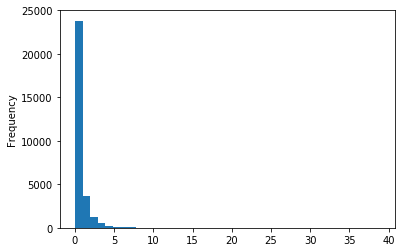

In [469]:
grouped['frp_std'].plot(kind='hist', bins=40)